In [1]:
import os
os.chdir('./../')

In [22]:
import dotenv
import random
import sqlite3
from typing import Annotated, TypedDict

import gradio as gr
from IPython.display import Image, display
from langchain.agents import Tool
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph import graph, prebuilt
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from pydantic import BaseModel

dotenv.load_dotenv(override=True)

from common.constants import Constants
from common.tools.pushover import Pushover

In [3]:
_ASSISTANT = 'assistant'
_CONTENT = 'content'
_NODE_CHATBOT = 'chatbot'
_NODE_FIRST = 'first_node'
_ROLE = 'role'
_TOOL_SEARCH = 'search'
_USER = 'user'

In [4]:
serper = GoogleSerperAPIWrapper()
serper.run("What is the capital of France?")

'Paris is the capital and largest city of France. With an estimated population of 2,048,472 in January 2025 in an area of more than 105 km2 (41 sq mi), ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. The capital of France has been Paris since its liberation in 1944. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most ... Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... The capital and by far the most important city of France is Paris, one of the world\'s preeminent cultural and commercial centres. Paris is the capital and mos

In [5]:
tool_search =Tool(name=_TOOL_SEARCH, func=serper.run, description="Useful for when you need more information from an online search")

In [6]:
tool_search.invoke("What is the capital of France?")

'Paris is the capital and largest city of France. With an estimated population of 2,048,472 in January 2025 in an area of more than 105 km2 (41 sq mi), ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. The capital of France has been Paris since its liberation in 1944. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most ... Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île- ... 7 likes, 0

In [7]:
Pushover.push('Hello')

In [8]:
tool_push = Tool(name="send_push_notification", func=Pushover.push, description="useful for when you want to send a push notification")

In [9]:
tool_push.invoke("Hello, me again!")

In [10]:
tools = [tool_search, tool_push]

In [11]:
class State(TypedDict):
    messages: Annotated[list, graph.add_messages]

In [12]:
graph_builder = graph.StateGraph(State)

In [13]:
llm = ChatGoogleGenerativeAI(model=Constants.GEMINI_MODEL_LITE)
llm_with_tools = llm.bind_tools(tools)

In [14]:
def chatbot(state: State) -> State:
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [15]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", prebuilt.ToolNode(tools=tools))

In [16]:
graph_builder.add_conditional_edges("chatbot", prebuilt.tools_condition, "tools")

In [17]:
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(graph.START, "chatbot")

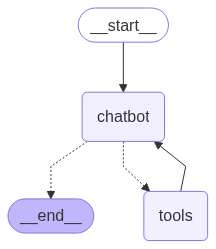

In [18]:
state_graph = graph_builder.compile()
display(Image(state_graph.get_graph().draw_mermaid_png()))

In [19]:
def chat(user_input: str, history):
    result = state_graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content

In [20]:
gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [23]:
memory = MemorySaver()

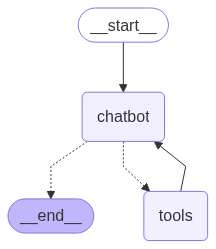

In [24]:
state_graph = graph_builder.compile(checkpointer=memory)
display(Image(state_graph.get_graph().draw_mermaid_png()))

In [26]:
# Thread id here is the conversation thread.
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    result = state_graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


In [27]:
state_graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Hello, my name is ABC', additional_kwargs={}, response_metadata={}, id='17376fe0-075b-407a-9409-84aad7726190'), AIMessage(content="Hi ABC, it's nice to meet you!", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite-preview-06-17', 'safety_ratings': []}, id='run--50b027d7-f79c-4ce8-8acd-db855b2478e8-0', usage_metadata={'input_tokens': 100, 'output_tokens': 11, 'total_tokens': 111, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}, id='a2215f74-6e20-45c9-b5c9-3239efca1660'), AIMessage(content='Your name is ABC.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite-preview-06-17', 'safety_ratings': []}, id='run--294d5909-a28f-4636-8f

In [28]:
list(state_graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='Hello, my name is ABC', additional_kwargs={}, response_metadata={}, id='17376fe0-075b-407a-9409-84aad7726190'), AIMessage(content="Hi ABC, it's nice to meet you!", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite-preview-06-17', 'safety_ratings': []}, id='run--50b027d7-f79c-4ce8-8acd-db855b2478e8-0', usage_metadata={'input_tokens': 100, 'output_tokens': 11, 'total_tokens': 111, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}, id='a2215f74-6e20-45c9-b5c9-3239efca1660'), AIMessage(content='Your name is ABC.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite-preview-06-17', 'safety_ratings': []}, id='run--294d5909-a28f-4636-8

In [30]:
db_path = './lang_graph_04/output/memory.db'
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

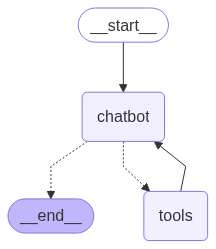

In [31]:
state_graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(state_graph.get_graph().draw_mermaid_png()))

In [33]:
config = {"configurable": {"thread_id": "3"}}

def chat(user_input: str, history):
    result = state_graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.
